# Analysing alanine dipeptide with TRAM
We want to find the potential of mean force (PMF) with respect to the torsion angles of alanine dipeptide.

Alanine dipeptide is a small peptide which is often used as a model system. It consists of 21 atoms, and we are interested in two backbone torsion angles $\phi$ and $\psi$.

![Alanine dipeptide](img/alanine.png)
(image source: https://www.cp2k.org/)

We want to know how alanine dipeptide is structured, specifically, what combinations of these two torsion angles are energetically favourable, and which are unfavourable.

To do this, simulations have been performed at 21 different temperatures between 300K and 500K. 10000 samples were taken at each thermodynamic state. We use SATRAM to combine the data from these different simulations, and to estimate the free energy of each state. We then reweight the samples to estimate the free energy surface as a function of the two torsion angles.

## Input data
The temperatures of the different replica's are given, as well as some imports and constants we will need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans


DIST = 10 # total number of temperature replicas (=simulations)
SAMPLES_PER_T = 10000 # number of samples that were taken per simulation

temperatures = np.arange(300, 501, DIST) # the temperatures of each simulation

N_REPLICAS = len(temperatures) # 21 replicas

# kBT in kJ/mol (at T=1K)
kB_kJ = 0.00831446261815324  

# kBT in kcal/mol (at T=1K)
kB_kcal = 0.0019872042586408316

The input data consists of energies and angles. These are loaded into lists, each lists is of length `N_REPLICAS`. The `i`-th element in each list contains the data for the temperature at index `i`. In other words:

* `angles[i][n]` is of shape `(2)` and contains angles $\phi$ and $\psi$ of the `n`-th sample taken in simulation `i` (i.e. at temperature `i`), in degrees.

* `energies[i][n]` is the potential energy belonging to that same sample, in kcal/mol. 

In [2]:
import examples.datasets.alanine_dipeptide_parallel_tempering as dataset

angles, energies = dataset.get_data()

print(f"angles    -    length: {len(angles)},  shape: {angles[0].shape}")
print(f"energies  -    length: {len(energies)},  shape: {energies[0].shape}")

3365888it [00:00, 4022409.01it/s]                                                                                                                                                                                 
1685504it [00:00, 3766621.91it/s]                                                                                                                                                                                 

angles    -    length: 21,  shape: (10000, 2)
energies  -    length: 21,  shape: (10000,)


### Constructing the bias matrix
The energies are used to fill the bias matrix. For each sample, the bias needs to be computed in each thermodynamic state. More specifically: for each sample, we compute the bias energy $b^k(x) = U^k(x) - U^0(x) = u(x)\;(\beta_k - \beta_0)$ for every thermodynamic state $k$, where $\beta_0$ is the inverse temperature of our unbiased state, in this case the state corresponding to the lowest temperature, $T=300K$.

The inverse temperature $\beta^k$ is computed for each thermodynamic state.

In [3]:
betas = (kB_kJ * temperatures.astype(float))**(-1)

Now we compute the bias matrices and add them to the list of length `N_REPLICAS`, with each bias matrix of shape `(SAMPLES_PER_T, N_REPLICAS)`. Each element `bias_matrices[k][n][l]` contains value $b^l(x_n^k)$, i.e. the bias energy of the $n$-th sample in the $k$-th trajectory, _evaluated at_ state $l$.

In [4]:
bias_matrices = []

for k, T in enumerate(temperatures):
    # apply the bias factors to the potential energies to produce bias energies
    bias_matrices.append((betas - betas[0]) * energies[k][:, None])
    
print(bias_matrices[0].shape)
len(bias_matrices)

(10000, 21)


21

### Discretizing the trajectories
The torsion angles $\phi$ and $\psi$ are transformed into discrete trajectories from which the transition counts are computed.

The angles are discretized into Markov states by use of the KMeans++ clustering algorithm as implemented in deeptime.

(see also https://deeptime-ml.github.io/latest/notebooks/clustering.html#k-means++-initialization)

In [5]:
clusterer = KMeans(
    n_clusters=20, # we will cluster data to 20 Markov states
    init_strategy='kmeans++',
    max_iter=10,
    fixed_seed=13,
    n_jobs=8
)
clustering = clusterer.fit(angles).fetch_model()

dtrajs = []

for A in angles:
    dtrajs.append(np.asarray(clustering.transform(A)))

print(dtrajs[0][:10])

[ 5 19  0  0  0  8  0  0  0  7]


C:\Users\Maaike\miniconda3\envs\satram\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


### ttrajs
Since no replica exchange was done, each samples thermodynamic state index is equal to its simulation index. The ttrajs kan thus be simply constructed as follows:

In [6]:
ttrajs = [np.asarray([i] * len(dtrajs[i])) for i in range(N_REPLICAS)]

### Analysing the data with TRAM
Now we use SATRAM to estimate the free energies. We run SATRAM for `max_iter` iteration. The batch size is doubled every 10 epochs.

In [7]:
from satram import ThermodynamicEstimator
from tqdm.notebook import tqdm

max_iter = 50

estimator = ThermodynamicEstimator(progress=tqdm, maxiter=max_iter, device='cuda', lagtime=10)
estimator.fit((ttrajs, dtrajs, bias_matrices), solver_type="SATRAM", patience=10)

  0%|          | 0/50 [00:00<?, ?it/s]

increasing batch size to 512, lr to 0.049377071987869406
increasing batch size to 1024, lr to 0.06982972487551756
increasing batch size to 2048, lr to 0.09875414397573881
increasing batch size to 4096, lr to 0.13965944975103511


### Recovering the PMF
Now we recover the free energy surface as a function of the torsion angles. For this, the two-dimensional angles are discretized into a one-dimensional set of bins over the space (-180, 180). The PMF is then computed over the bins

In [8]:
n_bins = 20
bins = np.linspace(-180, 180, n_bins, endpoint=True)

binned_angles = np.digitize(np.concatenate(angles), np.linspace(-180, 180, n_bins, endpoint=False), right=False) - 1
binned_trajectories = n_bins * binned_angles[:, 0] + binned_angles[:, 1]

In [9]:
pmf = estimator.compute_pmf(binned_trajectories, n_bins**2)

We plot the PMF in kcal/mol

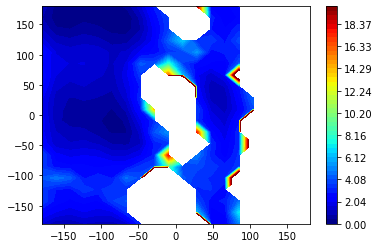

In [10]:
XS, YS = np.meshgrid(bins, bins)
pmf_kcal_mol = np.reshape(pmf, [n_bins, n_bins]).T * kB_kcal * 300
im = plt.contourf(XS, YS, pmf_kcal_mol, cmap='jet', levels=np.linspace(0, 20, 50))
plt.colorbar(im);